In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

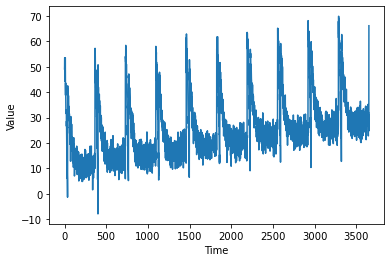

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [5]:
x_train.shape

(3000,)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 2)

In [8]:
time_train = time_train.reshape(time_train.shape[0], 1)

In [9]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [23]:
generator = TimeseriesGenerator(x_train, x_train, length = window_size, batch_size = batch_size, shuffle=True)

In [24]:
validation_generator = TimeseriesGenerator(x_valid, x_valid, length=window_size, batch_size = batch_size)

In [12]:
model_dnn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100,  activation='relu', input_dim=window_size), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model_dnn.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model_dnn.fit_generator(generator,epochs=100)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 94 steps
Epoch 1/100
94/94 [==============================] - 1s 6ms/step - loss: 72.8062
Epoch 2/100
94/94 [==============================] - 0s 2ms/step - loss: 40.2819
Epoch 3/100
94/94 [==============================] - 0s 2ms/step - loss: 33.1610
Epoch 4/100
94/94 [==============================] - 0s 2ms/step - loss: 29.6957
Epoch 5/100
94/94 [==============================] - 0s 2ms/step - loss: 28.5579
Epoch 6/100
94/94 [==============================] - 0s 2ms/step - loss: 27.1779
Epoch 7/100
94/94 [==============================] - 0s 2ms/step - loss: 26.7524
Epoch 8/100
94/94 [==============================] - 0s 2ms/step - loss: 26.0889
Epoch 9/100
94/94 [==============================] - 0s 2ms/step - loss: 26.1214
Epoch 10/100
94/94 [==============================] - 0s 2ms/step - loss: 25.2463
Epoch 11/100
94/94 [==============================] - 0s 2ms/step - l

94/94 [==============================] - 0s 2ms/step - loss: 20.8914
Epoch 97/100
94/94 [==============================] - 0s 2ms/step - loss: 21.2726
Epoch 98/100
94/94 [==============================] - 0s 2ms/step - loss: 21.0338
Epoch 99/100
94/94 [==============================] - 0s 2ms/step - loss: 20.8481
Epoch 100/100
94/94 [==============================] - 0s 2ms/step - loss: 20.7226


In [38]:
n_features = 1

model_rnn = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences="True")),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model_rnn.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [39]:
model_rnn.fit_generator(generator, epochs = 100, callbacks = [lr_schedule])

  ...
    to  
  ['...']
Train for 94 steps
Epoch 1/100
94/94 [==============================] - 6s 68ms/step - loss: 40.0158 - mae: 40.5158
Epoch 2/100
94/94 [==============================] - 1s 6ms/step - loss: 37.4965 - mae: 37.9965
Epoch 3/100
94/94 [==============================] - 1s 6ms/step - loss: 33.3005 - mae: 33.8005
Epoch 4/100
94/94 [==============================] - 1s 6ms/step - loss: 28.8161 - mae: 29.3161
Epoch 5/100
94/94 [==============================] - 1s 6ms/step - loss: 24.7440 - mae: 25.2427
Epoch 6/100
94/94 [==============================] - 1s 6ms/step - loss: 19.1039 - mae: 19.5959
Epoch 7/100
94/94 [==============================] - 1s 6ms/step - loss: 15.6641 - mae: 16.1539
Epoch 8/100
94/94 [==============================] - 1s 6ms/step - loss: 14.0539 - mae: 14.5451
Epoch 9/100
94/94 [==============================] - 1s 6ms/step - loss: 12.2529 - mae: 12.7436
Epoch 10/100
94/94 [==============================] - 1s 6ms/step - loss: 10.7756 - mae: 11

Epoch 86/100
94/94 [==============================] - 1s 6ms/step - loss: 3.5987 - mae: 4.0706
Epoch 87/100
94/94 [==============================] - 1s 7ms/step - loss: 3.3989 - mae: 3.8723
Epoch 88/100
94/94 [==============================] - 1s 6ms/step - loss: 3.7321 - mae: 4.2058
Epoch 89/100
94/94 [==============================] - 1s 6ms/step - loss: 3.2518 - mae: 3.7193
Epoch 90/100
94/94 [==============================] - 1s 6ms/step - loss: 3.3453 - mae: 3.8171
Epoch 91/100
94/94 [==============================] - 1s 6ms/step - loss: 3.5883 - mae: 4.0629
Epoch 92/100
94/94 [==============================] - 1s 6ms/step - loss: 3.9338 - mae: 4.4096
Epoch 93/100
94/94 [==============================] - 1s 6ms/step - loss: 3.3378 - mae: 3.8068
Epoch 94/100
94/94 [==============================] - 1s 6ms/step - loss: 3.3921 - mae: 3.8665
Epoch 95/100
94/94 [==============================] - 1s 6ms/step - loss: 3.4868 - mae: 3.9558
Epoch 96/100
94/94 [==============================

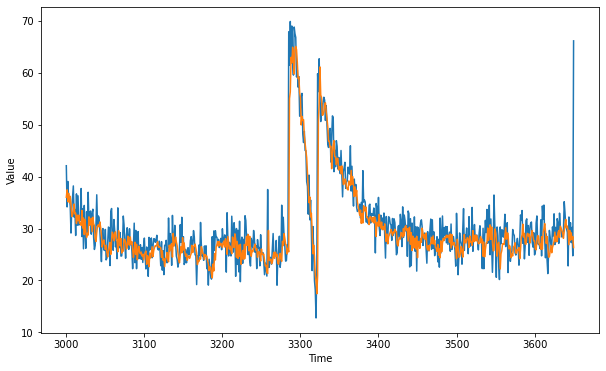

In [15]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model_dnn.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.051271

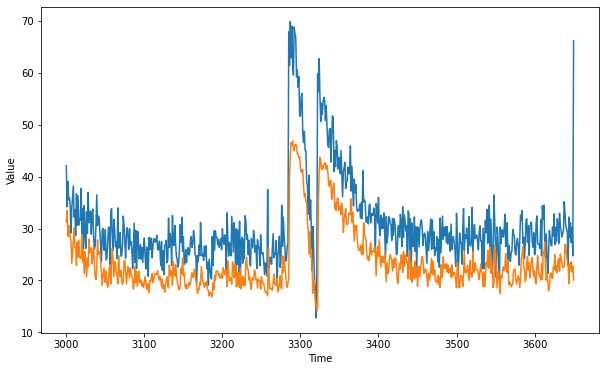

In [40]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model_rnn.predict(series[time:time + window_size][np.newaxis]))
forecast = forecast[len(x_train)-window_size:]
results = np.array(forecast)[:, 0, 0]
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [41]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

7.0951834